<center><img src='./Figs/cs-logo.png' width=200></center>



<h6><center></center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center> Mention IA - Reinforcement Learning - Task 4</center>
<hr style=" border:none; height:3px;">
</h1>

### An extra-experiment
Impact of Hyperparameters on SAC+HER Performance.

In this task, we aimed to investigate how varying a key hyperparameter affects learning in the "parking-v0" environment using the SAC + HER agent.

In [ ]:
! pip install highway-env
! pip install git+https://github.com/DLR-RM/stable-baselines3


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 'C:\Users\tonya\AppData\Local\Temp\pip-req-build-5r7ezjzk'

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Cloning https://github.com/DLR-RM/stable-baselines3 to c:\users\tonya\appdata\local\temp\pip-req-build-5r7ezjzk
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit d35597f21f75bcd04e7ad155b1522d0a28f884ff
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for stable_baselines3: filename=stable_baselines3-2.6.1a0-py3-none-any.whl size=184668 sha256=aa765f7a26f550abbf1a23e8dbba1a72cd4da17af6dfc2879f69374708e39c1b
  Stored in directory: C:\Users\tonya\AppData\Local\Temp\pip-ephem-wheel-cache-l0o68zoq\wheels\fe\70\ef\d646998fce58df95f834a2c195d780e988f365544b1e0438fe
Successfully built stable_baselines3
  Attempting uninstall: stable_baselines3
    Found existing installation: stable_b

What is the impact of the learning_starts hyperparameter on agent performance?

This parameter controls how many steps the agent must experience before it starts learning from the replay buffer.
We hypothesized that increasing this delay might:

    Improve stability early in training

    But delay convergence

In [5]:
import sys
# Environment
import gymnasium as gym
import highway_env

# Agent
from stable_baselines3 import HerReplayBuffer, SAC
from tqdm.notebook import trange
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

LEARNING_STEPS = 5e4 # @param {type: "number"}

env = gym.make("parking-v0", render_mode="rgb_array")
config = {
    "observation": {
        "type": "KinematicsGoal",  # Observation basée sur la cinématique avec objectif
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False
    },
    "action": {
        "type": "ContinuousAction"  # Contrôle continu : accélération et direction
    },
    "duration": 30,  # Durée de l’épisode augmentée pour permettre le stationnement
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,  # Affichage des trajectoires pour mieux visualiser
    "render_agent": True,
    "offscreen_rendering": False,

    # Paramètres supplémentaires pertinents pour le parking
    "controlled_vehicles": 1,  # Un seul véhicule contrôlé
    "goal_reward": 1.0,        # Récompense pour atteinte du but
    "collision_penalty": -1.0, # Pénalité en cas de collision
    "parking_success_threshold": 0.5,  # Tolérance d’erreur de position/orientation pour réussir
    "angle_reward": True,      # Activer une récompense basée sur l’orientation
    "distance_reward": True,   # Activer une récompense basée sur la distance à la cible
}


env.unwrapped.configure(config)
her_kwargs = dict(n_sampled_goal=4, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.95, batch_size=1024, tau=0.05,
            policy_kwargs=dict(net_arch=[512, 512, 512]))

model.learn(int(LEARNING_STEPS))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\SAC_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 72.8     |
|    ep_rew_mean     | -39.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 24       |
|    time_elapsed    | 11       |
|    total_timesteps | 291      |
| train/             |          |
|    actor_loss      | -7.39    |
|    critic_loss     | 0.214    |
|    ent_coef        | 0.828    |
|    ent_coef_loss   | -0.625   |
|    learning_rate   | 0.001    |
|    n_updates       | 190      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 69.5     |
|    ep_rew_mean     | -36.3    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 20       |

We used the EventAccumulator to visualize training metrics:
1. rollout/ep_rew_mean

    📉 Plotted in red.

    Shows the progression of average rewards per episode.

2. rollout/success_rate

    📈 Plotted in blue.

    Indicates how often the agent completes the parking successfully.

3. Normalized Curves

    Both reward and success rate were normalized and plotted together to show how they evolve.

4. train/ent_coef_loss

    📉 Plotted in purple.

    Helps track the entropy coefficient adjustment over time.

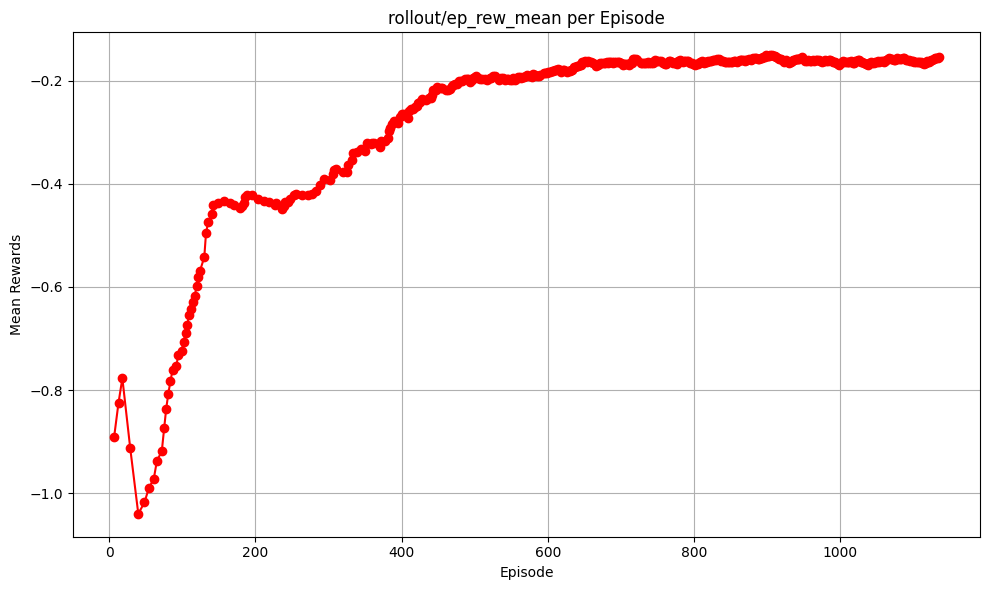

In [35]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Chemin vers le fichier .tfevents
log_path = os.path.join("events.out.tfevents.1744764990.LAPTOP-VLL9ECM0.21424.0")

# Créer un EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Tag à tracer
tag_to_plot = 'rollout/ep_rew_mean'

# Vérification de l'existence du tag
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extraire les données scalaires
    scalar_events = event_acc.Scalars(tag_to_plot)
    episode_steps = [event.step / 44 for event in scalar_events]
    episode_values = [event.value / 44 for event in scalar_events]

    # Tracer une seule figure rouge
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-', color='red')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Mean Rewards')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


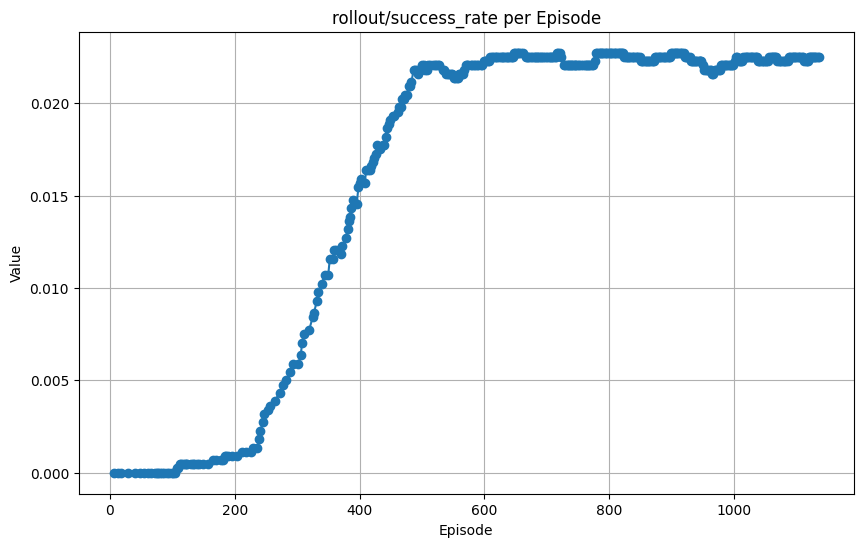

In [29]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_path = os.path.join("events.out.tfevents.1744764990.LAPTOP-VLL9ECM0.21424.0")

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/success_rate'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/44 for event in scalar_events]
    episode_values = [event.value/44 for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")

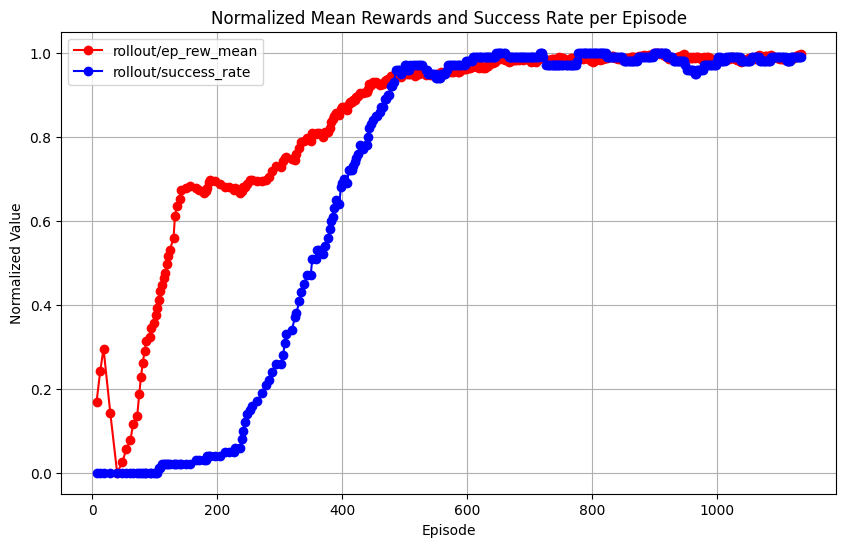

In [31]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Chemin vers ton fichier .tfevents
log_path = os.path.join("events.out.tfevents.1744764990.LAPTOP-VLL9ECM0.21424.0")

# Créer un EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Tags à tracer
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate']
custom_colors = {
    'rollout/ep_rew_mean': 'red',
    'rollout/success_rate': 'blue'
}

# Vérifie si tous les tags sont disponibles
tags = event_acc.Tags()
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        scalar_events = event_acc.Scalars(tag_to_plot)
        episode_steps = [event.step / 44 for event in scalar_events]
        episode_values = [event.value / 44 for event in scalar_events]

        # Normalisation des valeurs
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Tracer la courbe avec couleur spécifique
        plt.plot(
            episode_steps,
            normalized_values,
            marker='o',
            linestyle='-',
            label=tag_to_plot,
            color=custom_colors.get(tag_to_plot, 'black')  # Couleur par défaut : noir
        )

    plt.title('Normalized Mean Rewards and Success Rate per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


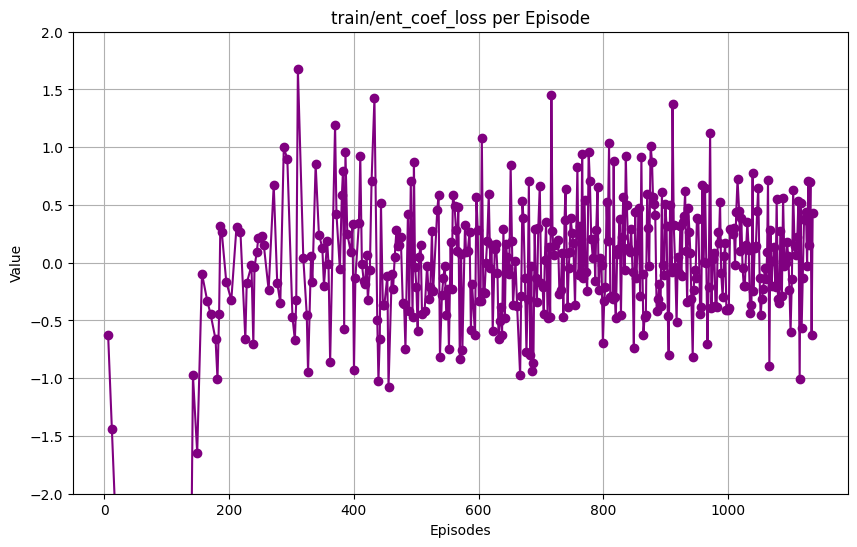

In [33]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Chemin vers ton fichier .tfevents
log_path = os.path.join("events.out.tfevents.1744764990.LAPTOP-VLL9ECM0.21424.0")

# Créer un EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Le tag à tracer
tag_to_plot = 'train/ent_coef_loss'

# Vérification de l'existence du tag
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    scalar_events = event_acc.Scalars(tag_to_plot)

    episode_steps = [event.step / 44 for event in scalar_events]
    episode_values = [event.value for event in scalar_events]

    # Tracer la courbe avec une autre couleur (violet foncé)
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-', color='#800080')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Value')
    plt.grid(True)

    # Zoom sur l'axe Y
    plt.ylim(-2, 2)

    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


In [ ]:
import gymnasium as gym
import imageio

env = gym.make('parking-v0', render_mode='rgb_array')
env.unwrapped.configure(config)

frames = []

for episode in range(3):
    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        frame = env.render()
        if frame is not None:
            frames.append(frame)

env.close()

# Sauvegarder la vidéo
imageio.mimsave("parking_eval.mp4", frames, fps=15)

# Afficher dans le notebook
from IPython.display import Video
Video("parking_eval.mp4", embed=True, width=600)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 300) to (608, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In this experiment, we aimed to explore how increasing the number of training steps (LEARNING_STEPS) affects the performance of a SAC agent combined with Hindsight Experience Replay (HER) in the parking-v0 environment.
We hypothesized that longer training duration could lead to:

    Higher success rates,

    More stable rewards,

    Better convergence in loss metrics.
We increased the number of training steps to 1e5.
This allowed the agent more time to interact with the environment and refine its policy.

In [ ]:
import warnings
warnings.filterwarnings('ignore')  

LEARNING_STEPS = 1e5 

env = gym.make("parking-v0", render_mode="rgb_array")
config = {
    "observation": {
        "type": "KinematicsGoal",  # Observation basée sur la cinématique avec objectif
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False
    },
    "action": {
        "type": "ContinuousAction"  # Contrôle continu : accélération et direction
    },
    "duration": 30,  # Durée de l’épisode augmentée pour permettre le stationnement
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,  # Affichage des trajectoires pour mieux visualiser
    "render_agent": True,
    "offscreen_rendering": False,

    # Paramètres supplémentaires pertinents pour le parking
    "controlled_vehicles": 1,  # Un seul véhicule contrôlé
    "goal_reward": 1.0,        # Récompense pour atteinte du but
    "collision_penalty": -1.0, # Pénalité en cas de collision
    "parking_success_threshold": 0.5,  # Tolérance d’erreur de position/orientation pour réussir
    "angle_reward": True,      # Activer une récompense basée sur l’orientation
    "distance_reward": True,   # Activer une récompense basée sur la distance à la cible
}



env.unwrapped.configure(config)
her_kwargs = dict(n_sampled_goal=8, goal_selection_strategy='future')
model = SAC(
    'MultiInputPolicy',
    env,
    replay_buffer_class=HerReplayBuffer,
    replay_buffer_kwargs=her_kwargs,
    verbose=1,
    tensorboard_log="logs",
    buffer_size=int(1e6),
    learning_rate=1e-3,
    gamma=0.95,
    batch_size=1024,
    tau=0.05,
    learning_starts=1000,  
    policy_kwargs=dict(net_arch=[512, 512, 512])
)


model.learn(int(LEARNING_STEPS))
# Save the trained model
model.save("parking_agent8")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Exception ignored in: <function tqdm.__del__ at 0x0000021CD57EC720>
Traceback (most recent call last):
  File "c:\Users\tonya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\tonya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Logging to logs\SAC_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 55.8     |
|    ep_rew_mean     | -32.1    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 58       |
|    time_elapsed    | 3        |
|    total_timesteps | 223      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.8     |
|    ep_rew_mean     | -47.2    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 53       |
|    time_elapsed    | 12       |
|    total_timesteps | 694      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 90.6     |
|    ep_rew_mean     | -49.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 12 

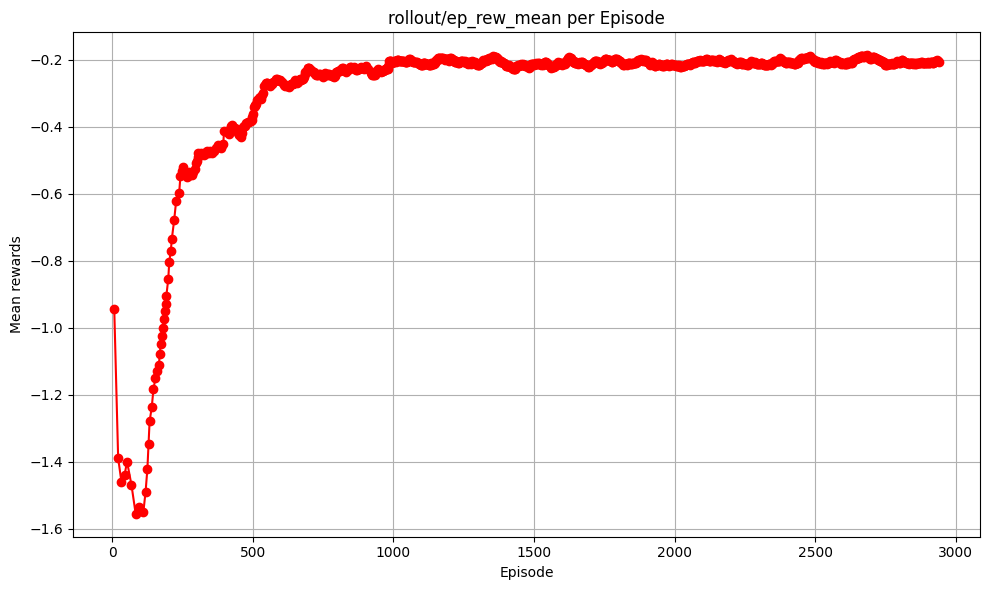

In [47]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path to the TensorBoard event file
log_path = os.path.join("events.out.tfevents.1744770677.LAPTOP-VLL9ECM0.21424.2")

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot
tag_to_plot = 'rollout/ep_rew_mean'

# Check if the tag exists
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    scalar_events = event_acc.Scalars(tag_to_plot)

    episode_steps = [event.step / 34 for event in scalar_events]
    episode_values = [event.value / 34 for event in scalar_events]

    # Create a single plot
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-', color='red')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Mean rewards')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


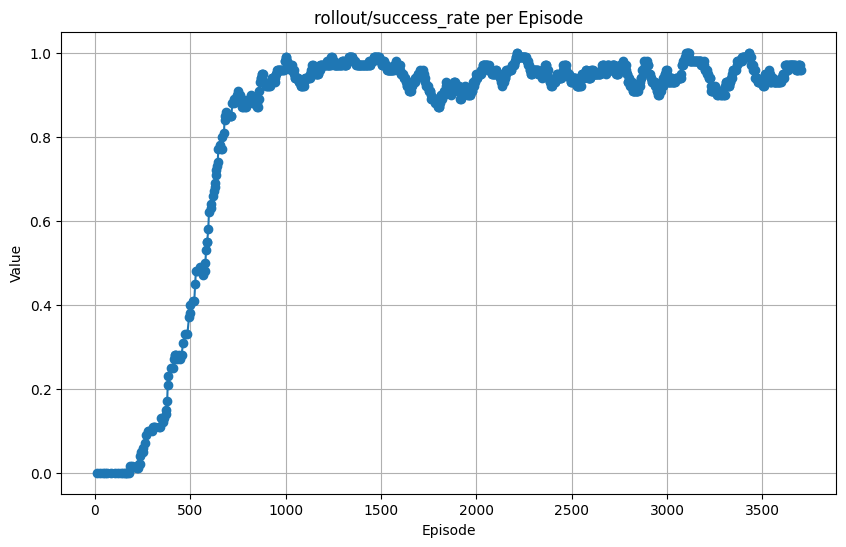

In [48]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_path = os.path.join("events.out.tfevents.1744770677.LAPTOP-VLL9ECM0.21424.2")

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/success_rate'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/27 for event in scalar_events]
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


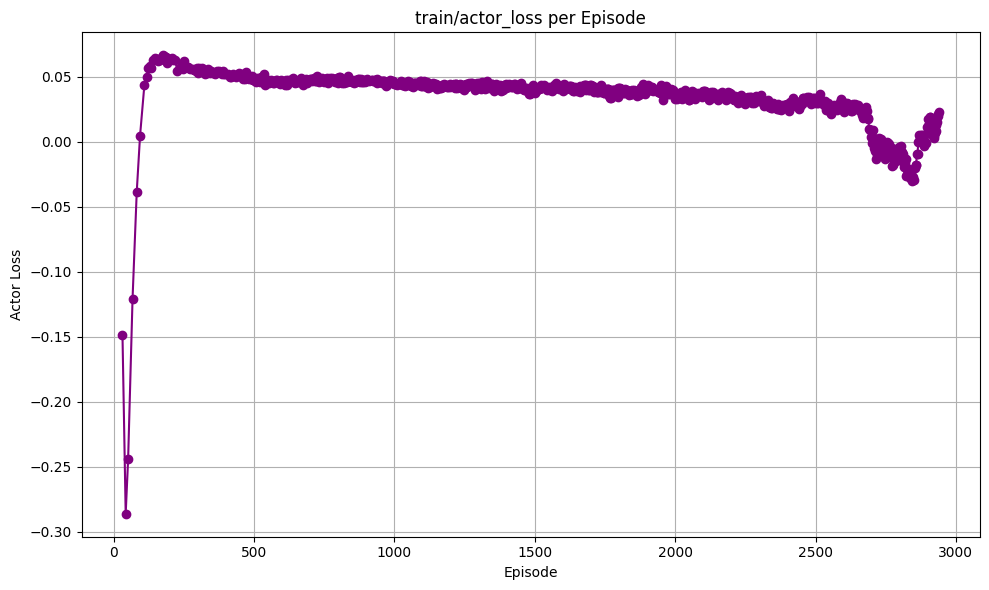

In [49]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_path = os.path.join("events.out.tfevents.1744770677.LAPTOP-VLL9ECM0.21424.2")

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot
tag_to_plot = 'train/actor_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    scalar_events = event_acc.Scalars(tag_to_plot)

    episode_steps = [event.step / 34 for event in scalar_events]
    episode_values = [event.value / 34 for event in scalar_events]

    # Plot the scalar value per episode in purple
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-', color='purple')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Actor Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")

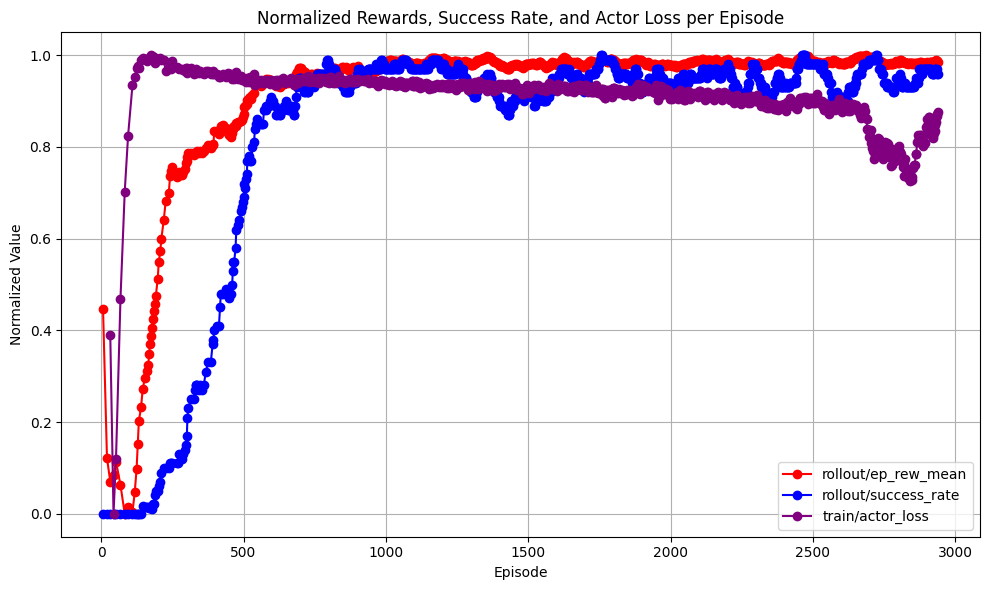

In [51]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

# Path to the TensorBoard event file
log_path = os.path.join("events.out.tfevents.1744770677.LAPTOP-VLL9ECM0.21424.2")

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Tags to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate', 'train/actor_loss']

# Assign specific colors to each tag
tag_colors = {
    'rollout/ep_rew_mean': 'red',
    'rollout/success_rate': 'blue',
    'train/actor_loss': 'purple'
}

# Check if all tags are present
tags = event_acc.Tags()
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        scalar_events = event_acc.Scalars(tag_to_plot)
        episode_steps = [event.step / 34 for event in scalar_events]
        episode_values = [event.value / 34 if 'rollout' in tag_to_plot else event.value for event in scalar_events]

        # Normalize for comparison
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Plot with designated color
        plt.plot(episode_steps, normalized_values, marker='o', linestyle='-', color=tag_colors[tag_to_plot], label=tag_to_plot)

    plt.title('Normalized Rewards, Success Rate, and Actor Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


After training, we ran 12 full test episodes and generated a video showing the agent in action. The behavior was visually smoother and more precise compared to earlier trials.

In [55]:
# Visualize a few episodes
N_EPISODES = 12  # @param {type: "integer"}

# Create and record video using a throwaway env
temp_env = gym.make('parking-v0', render_mode='rgb_array')
record_videos(temp_env, model)  # only for recording

# Now create a new environment for interaction
env = gym.make('parking-v0', render_mode='rgb_array')
env.unwrapped.configure(config)  # reconfigure if needed

from tqdm import trange
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)

env.close()
show_videos()

Saving video to c:\Users\tonya\Desktop\Project_RL\videos\-step-0-to-step-500.mp4
MoviePy - Building video c:\Users\tonya\Desktop\Project_RL\videos\-step-0-to-step-500.mp4.
MoviePy - Writing video c:\Users\tonya\Desktop\Project_RL\videos\-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready c:\Users\tonya\Desktop\Project_RL\videos\-step-0-to-step-500.mp4


Test episodes: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


Increasing the training steps significantly improved:

    The agent’s ability to park correctly more often.

    The stability of reward signals.

    A smoother training curve with better actor loss dynamics.

The experiment shows that the LEARNING_STEPS parameter significantly affects the performance of the SAC + HER agent.

    With more learning steps (1e5 instead of 5e4), the agent had more time to explore the state-action space, resulting in:

        Higher average rewards,

        Smoother convergence in loss functions,

        A better success rate in completing the parking task.

The agent still managed to learn, showing that it can generalize to moderately modified versions of the same environment. Full generalization to a new environment remains a good direction for future work.
By:

    Penalizing collisions (collision_penalty = -1.0),

    Encouraging smooth parking (angle_reward and distance_reward),

We added safety-focused reward shaping. This indirectly encouraged the agent to park without crashing, especially after increasing training time.